In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


from keras.models import Sequential, Model
from keras.layers import Conv1D, Conv2D, Conv2DTranspose,MaxPooling1D, Dense, Dropout, Flatten, Input,Lambda
from keras.layers import LSTM, TimeDistributed
from keras import layers
from keras import backend as K

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# ES 201 Final Project: Stress Detection

#### Elizabeth Healey and Bobby Gonzalez

# Outline

1. Introduction
2. Data Collection Process
3. Data Visualization
4. Classification
    
    i. Logistic Regression
    
    ii. Decision Tree
    
    iii.  Convolutional Neural Network
    
5. Latent and Generative Modeling
6. Conclusion 

# 1. Introduction


The goal of this project is to infer patterns of stress activity. We want to use biometric data gathered from human subjects to be able to identify cognitive stress and create a model for predicting whether a person is stressed or not based on biological signals. 

We first conducted a literature survey to learn about state-of-the-art stress detection methods using biomedical data. We found that Electrodermal Skin Response (EDA) and Heart Rate[HR] are signals commonly used to detect responses in the autonomous nervous system due to stress [ Setz et al 2010].  Below shows an example of what an SCR looks like:
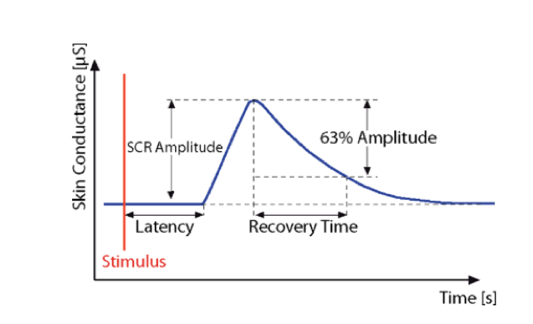

[Setz et al. 2010]

EDA signals have two different components commonly measured: Skin Conductive Response [SCR] and Skin Conductance Level [SCL]. SCR refer to short spikes in the EDA signal, directly related to the autonomous nervous system. SCL refers to the tonic level of the EDA signal, that rises and falls over time [Cho et. al 2017]. 


We found papers that use features extracted from these signals to classify stress. The paper [Cho et. al 2017] discusses extracting features from EDA and HR such as SCR amplitude, SCR average, HR variability. In this paper they were able to reach 95% accuracy in a controlled study. In a different study [Alexandratos et al.], they got only 79.7% accuracy in a controlled study just using features extracted from skin conductivity using Random Forest Classification.
A third paper that we found [Setz et al 2010] was able to get over 82% accuracy in a similar controlled study using LDA. In all of these papers, features from the EDA signal were extracted before putting them through a classification model. 

We wanted to try something different for our project. Our goal was to see if we could use a classification model directly on the raw EDA signal. So instead of extracting features from the EDA signal relating to amplitude, peak-to-peak interval, rise time, etc., we wanted to see if we could classify the signal by simply using the raw signal through a model that would learn the features on its own. 




# 2. Data Collection Process


In our initial iterations, we attempted to collect our own EDA data with the Empatica band in hopes of detecting stressful states. However, we ran into difficulties in effectively generated labelled datasets, and these difficulties included finding the right activities representative of stressful and relaxed states as well as synchronizing schedules with peers to source data from them. Moreover, had we sourced our own data from the Empatica band, we would have sourced at 4 Hz/sec instead of the sampling rate of the 8 Hz/sec in our final dataset. We instead looked to source time-series, EDA datasets available openly online. We initially found the Amigos dataset (link - http://www.eecs.qmul.ac.uk/mmv/datasets/amigos/readme.html), but this dataset was not available publicly. Moreover, it consisted of participants labelling videos (with many more options than stressed and relaxed), and therefore this dataset did not fit the current scope of our project. A second dataset that we found on Github, posted openly for Columbia University's HealthHacks conference (https://github.com/health-hacks), included samples of EDA data signals sourced from the Empatica band and a corresponding Excel file with time markers for when the stressful and relaxing stimuli were employed. However, this set only included on the order of 10 examples, and we also found the time markers to be inconsistent. 


The dataset that we decided on was data from the University of Texas Dallas [https://www.utdallas.edu/~nourani/Bioinformatics/Biosensor_Data/] . This dataset was from a study involving 20 subjects who would relax for 5 minutes,  be exposed to 5 minutes of a cognitive stress-inducing activity, and then relax for 5 mintutes. The dataset included EDA data from 20 subjects with labels of "stress" and "relax". The EDA was sampled at 8Hz. The was the largest dataset we could find, as well as the most reliable. 

# 3.  Data Visualization

After finding a dataset, our first step in determining what techniques to use was to visualize the data. Below we took the data split it up into "stressed" and "relaxed" data for each subject.  As mentioned previously, for each subject, there was a ~5minute period of relaxation, a ~5 minute period of coginitve stress, followed by a ~5 minute period of relaxation. We looked at these 3 periods of time for the 20 subjects. We put both portions of "relax" in the same category of "relaxed", even though the EDA signal differed. Our goal was to be able to detect the specific shape of the stress response. 

Below, we plotted data for the 20 subjects. For each subject, there is a plot of the two "relaxed" portions (which differed from one another) and the "stressed" portion. Visually, it is clear that the "stressed" portions differ from the "relaxed" portions. The "stressed" portion contains a signature spike (SCR) that corresponds to reactions of the autonomous nervous system. 

Our goal became to be able to predict whether or not a subject was in this state of cognitive stress, which is distinguished by the spikes. 

### Import Data

Below, each plot shows time on the X-axis, with the units being 1/8 of a second. This is because 8Hz was the sampling frequency. The Y axis is the EDA signal in uS. 
##### Subject 1


In [ ]:
data = 'Subject1AccTempEDA.csv'

sub_1 = pd.read_csv(data, delimiter = ",")

#print(sub_1)
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values

eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size

labels = np.zeros((length))


_1stress1 = []
_1stressE1 = []
_1stressE2 = []
_1relax1= []
_1relax2= []
_1relax3= []
_1relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
           
        labels[i] = 0
        if rc == 0:
            _1relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _1relax2.append(eda[i])
        elif rc == 2:
            _1relax3.append(eda[i])
        else:
            _1relax4.append(eda[i])
        
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _1stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _1stressE1.append( eda[i])
        elif rc == 1:
            _1stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

#plt.plot(eda)
#plt.plot(labels)

plt.show()
plt.figure()
plt.title('Subject 1 Relaxed Segments')
plt.plot(_1relax1)
#plt.plot(_1relax2)
plt.plot(_1relax3)
#plt.plot(_1relax4)
plt.show()

plt.figure()
plt.title('Subject 1 Stressed Segment')
plt.plot(_1stress1)
#plt.plot(stressE1)
plt.plot(_1stressE2)
plt.show()

##### Subject 2 

In [ ]:
data = 'Subject2AccTempEDA.csv'

sub_1 = pd.read_csv(data, delimiter = ",")

#print(sub_1)
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values

eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size

labels = np.zeros((length))


_2stress1 = []
_2stressE1 = []
_2stressE2 = []
_2relax1= []
_2relax2= []
_2relax3= []
_2relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _2relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _2relax2.append(eda[i])
        elif rc == 2:
            _2relax3.append(eda[i])
        else:
            _2relax4.append(eda[i])
        
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _2stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _2stressE1.append( eda[i])
        elif rc == 1:
            _2stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

#plt.plot(eda)
#plt.plot(labels)

#plt.show()


plt.figure()
plt.title('Subject 2 Relaxed Segments')
plt.plot(_2relax1)
#plt.plot(_2relax2)
plt.plot(_2relax3)
#plt.plot(_2relax4)
plt.show()

plt.figure()
plt.title('Subject 2 Stressed Segment')
plt.plot(_2stress1)
#plt.plot(stressE1)
plt.plot(_2stressE2)
plt.show()

##### Subject 3 

In [ ]:
data = 'Subject3AccTempEDA.csv'

sub_1 = pd.read_csv(data, delimiter = ",")

#print(sub_1)
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values

eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size

labels = np.zeros((length))


_3stress1 = []
_3stressE1 = []
_3stressE2 = []
_3relax1= []
_3relax2= []
_3relax3= []
_3relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _3relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _3relax2.append(eda[i])
        elif rc == 2:
            _3relax3.append(eda[i])
        else:
            _3relax4.append(eda[i])
        
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _3stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _3stressE1.append( eda[i])
        elif rc == 1:
            _3stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

#print(length)
#plt.plot(eda)
#plt.plot(labels)

#plt.show()


plt.figure()
plt.title('Subject 3 Relaxed Segments')
plt.plot(_3relax1)
#plt.plot(_3relax2)
plt.plot(_3relax3)
#plt.plot(_3relax4)
plt.show()

plt.figure()
plt.title('Subject 3 Stress Segment')
plt.plot(_3stress1)
#plt.plot(stressE1)
#plt.plot(_3stressE2)
plt.show()

##### Subject 4 

In [ ]:
data = 'Subject4AccTempEDA.csv'

sub_1 = pd.read_csv(data, delimiter = ",")

#print(sub_1)
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values

eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size

labels = np.zeros((length))


_4stress1 = []
_4stressE1 = []
_4stressE2 = []
_4relax1= []
_4relax2= []
_4relax3= []
_4relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
        labels[i] = 0
        if rc == 0:
            _4relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _4relax2.append(eda[i])
        elif rc == 2:
            _4relax3.append(eda[i])
        else:
            _4relax4.append(eda[i])
        
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _4stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _4stressE1.append( eda[i])
        elif Esc == 1:
            _4stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

#print(length)
#plt.plot(eda)
#plt.plot(labels)

#plt.show()


plt.figure()
plt.title('Subject 4 Relaxed Segments')
plt.plot(_4relax1)
#plt.plot(_4relax2)
plt.plot(_4relax3)
#plt.plot(_4relax4)
plt.show()

plt.figure()
plt.title('Subject 4 stressed Segment')


plt.plot(_4stress1)
#plt.plot(stressE1)
#plt.plot(_4stressE2)
plt.show()



##### Subject 5 

In [ ]:
data = 'Subject5AccTempEDA.csv'

sub_1 = pd.read_csv(data, delimiter = ",")

#print(sub_1)
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values

eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size

labels = np.zeros((length))


_5stress1 = []
_5stressE1 = []
_5stressE2 = []
_5relax1= []
_5relax2= []
_5relax3= []
_5relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
           
        labels[i] = 0
        if rc == 0:
            _5relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _5relax2.append(eda[i])
        elif rc == 2:
            _5relax3.append(eda[i])
        else:
            _5relax4.append(eda[i])
        
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _5stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _5stressE1.append( eda[i])
        elif Esc == 1:
            _5stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

#plt.plot(eda)
#plt.plot(labels)

#plt.show()


plt.figure()
plt.title('Subject 5 Relaxed Segments')
plt.plot(_5relax1)
#plt.plot(_5relax2)
plt.plot(_5relax3)
#plt.plot(_5relax4)
plt.xlabel('seconds')
plt.ylabel('uS')
plt.show()

plt.figure()
plt.title('Subject 5 Stressed Segments')
plt.plot(_5stress1)
#plt.plot(stressE1)
plt.xlabel('seconds')
plt.ylabel('uS')
plt.show()



##### Subject 6 

In [ ]:
data = 'Subject6AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_6stress1 = []
_6stressE1 = []
_6stressE2 = []
_6relax1= []
_6relax2= []
_6relax3= []
_6relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _6relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _6relax2.append(eda[i])
        elif rc == 2:
            _6relax3.append(eda[i])
        else:
            _6relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _6stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _6stressE1.append( eda[i])
        elif Esc == 1:
            _6stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#print(length)
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 6 Relaxed Segments')
plt.plot(_6relax1)
#plt.plot(_6relax2)
plt.plot(_6relax3)
#plt.plot(_6relax4)
plt.show()
plt.figure()
plt.title('Subject 6 Stressed Segments')
plt.plot(_6stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 7 

In [ ]:
data = 'Subject7AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_7stress1 = []
_7stressE1 = []
_7stressE2 = []
_7relax1= []
_7relax2= []
_7relax3= []
_7relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _7relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _7relax2.append(eda[i])
        elif rc == 2:
            _7relax3.append(eda[i])
        else:
            _7relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _7stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _7stressE1.append( eda[i])
        elif Esc == 1:
            _7stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#print(length)
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 7 Relaxed Segments')
plt.plot(_7relax1)
#plt.plot(_7relax2)
plt.plot(_7relax3)
#plt.plot(_7relax4)
plt.show()
plt.figure()
plt.title('Subject 7 Stressed Segments')


plt.plot(_7stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 8 

In [ ]:
data = 'Subject8AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_8stress1 = []
_8stressE1 = []
_8stressE2 = []
_8relax1= []
_8relax2= []
_8relax3= []
_8relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _8relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _8relax2.append(eda[i])
        elif rc == 2:
            _8relax3.append(eda[i])
        else:
            _8relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _8stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _8stressE1.append( eda[i])
        elif Esc == 1:
            _8stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#print(length)
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 8 Relaxed Segments')


plt.plot(_8relax1)
#plt.plot(_8relax2)
plt.plot(_8relax3)
#plt.plot(_8relax4)
plt.show()
plt.figure()
plt.title('Subject 8 Stressed Segments')
plt.plot(_8stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 9 

In [ ]:
data = 'Subject9AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_9stress1 = []
_9stressE1 = []
_9stressE2 = []
_9relax1= []
_9relax2= []
_9relax3= []
_9relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _9relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _9relax2.append(eda[i])
        elif rc == 2:
            _9relax3.append(eda[i])
        else:
            _9relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _9stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _9stressE1.append( eda[i])
        elif Esc == 1:
            _9stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 9 Relaxed Segments')
plt.plot(_9relax1)
#plt.plot(_9relax2)
plt.plot(_9relax3)
#plt.plot(_9relax4)
plt.xlabel('samples')
plt.ylabel('uS')
plt.show()
plt.figure()
plt.title('Subject 9 Stressed Segments')


plt.plot(_9stress1)
plt.xlabel('samples')
plt.ylabel('uS')
#plt.plot(stressE1)
plt.show()


##### Subject 10 

In [ ]:
data = 'Subject10AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_10stress1 = []
_10stressE1 = []
_10stressE2 = []
_10relax1= []
_10relax2= []
_10relax3= []
_10relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _10relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _10relax2.append(eda[i])
        elif rc == 2:
            _10relax3.append(eda[i])
        else:
            _10relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _10stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _10stressE1.append( eda[i])
        elif Esc == 1:
            _10stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 10 Relaxed Segments')
plt.plot(_10relax1)
#plt.plot(_10relax2)
plt.plot(_10relax3)
#plt.plot(_10relax4)
plt.show()
plt.figure()
plt.title('Subject 10 Stress Segments')
plt.plot(_10stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 11 

In [ ]:
data = 'Subject11AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_11stress1 = []
_11stressE1 = []
_11stressE2 = []
_11relax1= []
_11relax2= []
_11relax3= []
_11relax4= []
rc = 0
sc = 0
Esc = 0

# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _11relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _11relax2.append(eda[i])
        elif rc == 2:
            _11relax3.append(eda[i])
        else:
            _11relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _11stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _11stressE1.append( eda[i])
        elif Esc == 1:
            _11stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#print(length)
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 11 Relaxed Segments')
plt.plot(_11relax1)
#plt.plot(_11relax2)
plt.plot(_11relax3)
#plt.plot(_11relax4)
plt.show()
plt.figure()
plt.title('Subject 11 Stress Segments')
plt.plot(_11stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 12

In [ ]:
data = 'Subject12AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_12stress1 = []
_12stressE1 = []
_12stressE2 = []
_12relax1= []
_12relax2= []
_12relax3= []
_12relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
           
        labels[i] = 0
        if rc == 0:
            _12relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _12relax2.append(eda[i])
        elif rc == 2:
            _12relax3.append(eda[i])
        else:
            _12relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _12stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _12stressE1.append( eda[i])
        elif Esc == 1:
            _12stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
#print(length)
#plt.plot(eda)
#plt.plot(labels)
#plt.show()
plt.figure()
plt.title('Subject 12 Relaxed Segments')
plt.plot(_12relax1)
#plt.plot(_12relax2)
plt.plot(_12relax3)
#plt.plot(_12relax4)
plt.show()
plt.figure()
plt.title('Subject 12 Stress Segment')
plt.plot(_12stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 13 

In [ ]:
data = 'Subject13AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_13stress1 = []
_13stressE1 = []
_13stressE2 = []
_13relax1= []
_13relax2= []
_13relax3= []
_13relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
      
        labels[i] = 0
        if rc == 0:
            _13relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _13relax2.append(eda[i])
        elif rc == 2:
            _13relax3.append(eda[i])
        else:
            _13relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _13stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _13stressE1.append( eda[i])
        elif Esc == 1:
            _13stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 13 Relaxed Segments')
plt.plot(_13relax1)
#plt.plot(_13relax2)
plt.plot(_13relax3)
#plt.plot(_13relax4)
plt.show()
plt.figure()
plt.title('Subject 13 Stress Segment')
plt.plot(_13stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 14 

In [ ]:
data = 'Subject14AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_14stress1 = []
_14stressE1 = []
_14stressE2 = []
_14relax1= []
_14relax2= []
_14relax3= []
_14relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
           
        labels[i] = 0
        if rc == 0:
            _14relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _14relax2.append(eda[i])
        elif rc == 2:
            _14relax3.append(eda[i])
        else:
            _14relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _14stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _14stressE1.append( eda[i])
        elif Esc == 1:
            _14stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 14 Relaxed Segments')
plt.plot(_14relax1)
#plt.plot(_14relax2)
plt.plot(_14relax3)
#plt.plot(_14relax4)
plt.show()
plt.figure()
plt.title('Subject 14 Stress Segment')
plt.plot(_14stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 15

In [ ]:
data = 'Subject15AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_15stress1 = []
_15stressE1 = []
_15stressE2 = []
_15relax1= []
_15relax2= []
_15relax3= []
_15relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
           
        labels[i] = 0
        if rc == 0:
            _15relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _15relax2.append(eda[i])
        elif rc == 2:
            _15relax3.append(eda[i])
        else:
            _15relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _15stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _15stressE1.append( eda[i])
        elif Esc == 1:
            _15stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1
plt.figure()
plt.title('Subject 15 Relaxed Segments')
plt.plot(_15relax1)
#plt.plot(_15relax2)
plt.plot(_15relax3)
#plt.plot(_15relax4)
plt.show()
plt.figure()
plt.title('Subject 15 Stress Segment')
plt.plot(_15stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 16 

In [ ]:
data = 'Subject16AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_16stress1 = []
_16stressE1 = []
_16stressE2 = []
_16relax1= []
_16relax2= []
_16relax3= []
_16relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
   
        labels[i] = 0
        if rc == 0:
            _16relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _16relax2.append(eda[i])
        elif rc == 2:
            _16relax3.append(eda[i])
        else:
            _16relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _16stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _16stressE1.append( eda[i])
        elif Esc == 1:
            _16stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 16 Relaxed Segments')
plt.plot(_16relax1)
#plt.plot(_16relax2)
plt.plot(_16relax3)
#plt.plot(_16relax4)
plt.show()
plt.figure()
plt.title('Subject 16 Stress Segments')
plt.plot(_16stress1)
#plt.plot(stressE1)
plt.show()


##### SUbject 17

In [ ]:
data = 'Subject17AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_17stress1 = []
_17stressE1 = []
_17stressE2 = []
_17relax1= []
_17relax2= []
_17relax3= []
_17relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _17relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _17relax2.append(eda[i])
        elif rc == 2:
            _17relax3.append(eda[i])
        else:
            _17relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _17stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _17stressE1.append( eda[i])
        elif Esc == 1:
            _17stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 17 Relaxed Segments')


plt.plot(_17relax1)
#plt.plot(_17relax2)
plt.plot(_17relax3)
#plt.plot(_17relax4)
plt.show()
plt.figure()
plt.title('Subject 17 Stressed Segments')
plt.plot(_17stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 18 

In [ ]:
data = 'Subject18AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_18stress1 = []
_18stressE1 = []
_18stressE2 = []
_18relax1= []
_18relax2= []
_18relax3= []
_18relax4= []
rc = 0
sc = 0
Esc = 0

for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _18relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _18relax2.append(eda[i])
        elif rc == 2:
            _18relax3.append(eda[i])
        else:
            _18relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _18stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _18stressE1.append( eda[i])
        elif Esc == 1:
            _18stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 18 Relaxed Segments')
plt.plot(_18relax1)
#plt.plot(_18relax2)
plt.plot(_18relax3)
#plt.plot(_18relax4)
plt.show()
plt.figure()
plt.title('Subject 18 Stressed Segment')
plt.plot(_18stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 19

In [ ]:
data = 'Subject19AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_19stress1 = []
_19stressE1 = []
_19stressE2 = []
_19relax1= []
_19relax2= []
_19relax3= []
_19relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
          
        labels[i] = 0
        if rc == 0:
            _19relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _19relax2.append(eda[i])
        elif rc == 2:
            _19relax3.append(eda[i])
        else:
            _19relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _19stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _19stressE1.append( eda[i])
        elif Esc == 1:
            _19stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 19 Relaxed Segments')


plt.plot(_19relax1)
#plt.plot(_19relax2)
plt.plot(_19relax3)
#plt.plot(_19relax4)
plt.show()
plt.figure()
plt.title('Subject 19 Stressed Segment')
plt.plot(_19stress1)
#plt.plot(stressE1)
plt.show()


##### Subject 20 

In [ ]:
data = 'Subject20AccTempEDA.csv'
sub_1 = pd.read_csv(data, delimiter = ",")
eda = sub_1[['EDA']]
label = sub_1[['Label']]
label = label.values
eda = eda.values
shape = label.shape
part = label[:,0]
length = part.size
labels = np.zeros((length))
_20stress1 = []
_20stressE1 = []
_20stressE2 = []
_20relax1= []
_20relax2= []
_20relax3= []
_20relax4= []
rc = 0
sc = 0
Esc = 0
# Get labels 
for i in range(length):
    if label[[i]] == 'Relax':
        if i>1 and label[[i-1]] != label[[i]]:
            rc = rc+1
            
        labels[i] = 0
        if rc == 0:
            _20relax1.append(eda[i])
            if i>5000:
                print('hi')
        elif rc == 1:
            _20relax2.append(eda[i])
        elif rc == 2:
            _20relax3.append(eda[i])
        else:
            _20relax4.append(eda[i])      
    elif label[[i]] == 'CognitiveStress':
        labels[i] = 1
        _20stress1.append( eda[i])
    elif label[[i]] == 'EmotionalStress':
        if i>100000 and label[[i-1]] != label[[i]]:
            Esc = Esc+1
        if Esc == 0:
            _20stressE1.append( eda[i])
        elif Esc == 1:
            _20stressE2.append(eda[i])

        labels[i] = 3
    else:
        labels[i] = -1

plt.figure()
plt.title('Subject 20 Relaxed Segments')
plt.plot(_20relax1)
#plt.plot(_20relax2)
plt.plot(_20relax3)
#plt.plot(_20relax4)
plt.show()
plt.figure()
plt.title('Subject 20 Stressed Segment')
plt.plot(_20stress1)
#plt.plot(stressE1)
plt.show()


#  Data Processing 

Sampling Frequency is 8Hz. 
Each 'Relaxed' portion was a little under 5 minutes for each subject. Each "Stressed" portion was a little over 5 minutes for each subject. Because of this, we took 2000 samples, sampled at 8Hz, from each "relaxed" portion and then 2500 samples, sampled at 8Hz, for each "stressed" sample. 


Below is our step by step methodology for processing the data. 

#### Step 1:  Chunk Data 

In [ ]:
_1stress = np.vstack(_1stress1)
_2stress = np.vstack(_2stress1)
_3stress = np.vstack(_3stress1)
_4stress = np.vstack(_4stress1)
_5stress = np.vstack(_5stress1)
_6stress = np.vstack(_6stress1)
_7stress = np.vstack(_7stress1)
_8stress = np.vstack(_8stress1)
_9stress = np.vstack(_9stress1)
_10stress = np.vstack(_10stress1)
_11stress = np.vstack(_11stress1)
_12stress = np.vstack(_12stress1)
_13stress = np.vstack(_13stress1)
_14stress = np.vstack(_14stress1)
_15stress = np.vstack(_15stress1)
_16stress = np.vstack(_16stress1)
_17stress = np.vstack(_17stress1)
_18stress = np.vstack(_18stress1)
_19stress = np.vstack(_19stress1)
_20stress = np.vstack(_20stress1)

##### Dimension of Stress Matrix: 2500 x 20
Each subject had stressed data around 2800 samples.
We chose to make them all of length 2500 samples (about 5 minutes)


In [ ]:
s1 = _1stress[-2500:,:]
s2 = _2stress[-2500:,:]
s3 = _3stress[-2500:,:]
s4 = _4stress[-2500:,:]
s5 = _5stress[-2500:,:]
s6 = _6stress[-2500:,:]
s7 = _7stress[-2500:,:]
s8 = _8stress[-2500:,:]
s9 = _9stress[-2500:,:]
s10 = _10stress[-2500:,:]
s11 = _11stress[-2500:,:]
s12 = _12stress[-2500:,:]
s13 = _13stress[-2500:,:]
s14 = _14stress[-2500:,:]
s15 = _15stress[-2500:,:]
s16 = _16stress[-2500:,:]
s17 = _17stress[-2500:,:]
s18 = _18stress[-2500:,:]
s19 = _19stress[-2500:,:]
s20 = _20stress[-2500:,:]

s = np.concatenate([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20], axis = 1)
plt.figure(figsize= (20,5))
plt.title('20 Subjects Stress')
plt.xlabel('Samples at Fs=8Hz')
plt.ylabel('uS')
plt.plot(s)
plt.show()

Subjects 3, 6, 11, 18, 19 had very poor EDA data for the stress period. The data here was of very small magnitudes. Our guess is that this was an error in how the sensor was worn.

Since we know the type of signals we are looking for to detect a fluctuation of the autonomous nervous system, we thought for our purposes it would be beneficial to remove these 5 subjects data. 

In [ ]:
st = np.concatenate([s1,s2,s4,s5,s7,s8,s9,s10,s12,s13,s14,s15,s16,s17,s20], axis = 1)
plt.figure(figsize= (20,5))
plt.title('15 Subjects Stress')
plt.xlabel('Samples at Fs=8Hz')
plt.ylabel('uS')
plt.plot(st)
plt.show()

##### Dimensions of Relaxed Data
For each subject, there were 2 different 5 minute intervals. One was the first 5 minutes, and the other was 5 minutes after the "stressed" portion. 


"relax1" is the first 5 minutes 

"relax3" is the 5 minutes after the period of stress 

For each subject, I segmented them all into length 2000 samples



In [ ]:
_1relax1 = np.vstack(_1relax1)
_2relax1 = np.vstack(_2relax1)
_3relax1 = np.vstack(_3relax1)
_4relax1 = np.vstack(_4relax1)
_5relax1 = np.vstack(_5relax1)
_6relax1 = np.vstack(_6relax1)
_7relax1 = np.vstack(_7relax1)
_8relax1 = np.vstack(_8relax1)
_9relax1 = np.vstack(_9relax1)
_10relax1 = np.vstack(_10relax1)
_11relax1 = np.vstack(_11relax1)
_12relax1 = np.vstack(_12relax1)
_13relax1 = np.vstack(_13relax1)
_14relax1 = np.vstack(_14relax1)
_15relax1 = np.vstack(_15relax1)
_16relax1 = np.vstack(_16relax1)
_17relax1 = np.vstack(_17relax1)
_18relax1 = np.vstack(_18relax1)
_19relax1 = np.vstack(_19relax1)
_20relax1 = np.vstack(_20relax1)

In [ ]:
r1_1 = _1relax1[-2000:,:]
r1_2 = _2relax1[-2000:,:]
r1_3 = _3relax1[-2000:,:]
r1_4 = _4relax1[-2000:,:]
r1_5 = _5relax1[-2000:,:]
r1_6 = _6relax1[-2000:,:]
r1_7 = _7relax1[-2000:,:]
r1_8 = _8relax1[-2000:,:]
r1_9 = _9relax1[-2000:,:]
r1_10 = _10relax1[-2000:,:]
r1_11 = _11relax1[-2000:,:]
r1_12 = _12relax1[-2000:,:]
r1_13 = _13relax1[-2000:,:]
r1_14 = _14relax1[-2000:,:]
r1_15 = _15relax1[-2000:,:]
r1_16 = _16relax1[-2000:,:]
r1_17 = _17relax1[-2000:,:]
r1_18 = _18relax1[-2000:,:]
r1_19 = _19relax1[-2000:,:]
r1_20 = _20relax1[-2000:,:]

r1 = np.concatenate([r1_1,r1_2,r1_3,r1_4,r1_5,r1_6,r1_7,r1_8,r1_9,r1_10,r1_11,r1_12,r1_13,r1_14,r1_15,r1_16,r1_17,r1_18,r1_19,r1_20], axis = 1)
plt.figure(figsize= (20,5))
plt.title('20 Subjects Relax1')
plt.xlabel('Samples at Fs=8Hz')
plt.ylabel('uS')
plt.plot(r1)
plt.show()

In [ ]:
_1relax3 = np.vstack(_1relax3)
_2relax3 = np.vstack(_2relax3)
_3relax3 = np.vstack(_3relax3)
_4relax3 = np.vstack(_4relax3)
_5relax3 = np.vstack(_5relax3)
_6relax3 = np.vstack(_6relax3)
_7relax3 = np.vstack(_7relax3)
_8relax3 = np.vstack(_8relax3)
_9relax3 = np.vstack(_9relax3)
_10relax3 = np.vstack(_10relax3)
_11relax3 = np.vstack(_11relax3)
_12relax3 = np.vstack(_12relax3)
_13relax3 = np.vstack(_13relax3)
_14relax3 = np.vstack(_14relax3)
_15relax3 = np.vstack(_15relax3)
_16relax3 = np.vstack(_16relax3)
_17relax3 = np.vstack(_17relax3)
_18relax3 = np.vstack(_18relax3)
_19relax3 = np.vstack(_19relax3)
_20relax3 = np.vstack(_20relax3)

In [ ]:
r3_1 = _1relax3[-2000:,:]
r3_2 = _2relax3[-2000:,:]
r3_3 = _3relax3[-2000:,:]
r3_4 = _4relax3[-2000:,:]
r3_5 = _5relax3[-2000:,:]
r3_6 = _6relax3[-2000:,:]
r3_7 = _7relax3[-2000:,:]
r3_8 = _8relax3[-2000:,:]
r3_9 = _9relax3[-2000:,:]
r3_10 = _10relax3[-2000:,:]
r3_11 = _11relax3[-2000:,:]
r3_12 = _12relax3[-2000:,:]
r3_13 = _13relax3[-2000:,:]
r3_14 = _14relax3[-2000:,:]
r3_15 = _15relax3[-2000:,:]
r3_16 = _16relax3[-2000:,:]
r3_17 = _17relax3[-2000:,:]
r3_18 = _18relax3[-2000:,:]
r3_19 = _19relax3[-2000:,:]
r3_20 = _20relax3[-2000:,:]

r3 = np.concatenate([r3_1,r3_2,r3_3,r3_4,r3_5,r3_6,r3_7,r3_8,r3_9,r3_10,r3_11,r3_12,r3_13,r3_14,r3_15,r3_16,r3_17,r3_18,r3_19,r3_20], axis = 1)
plt.figure(figsize= (20,5))
plt.title('20 Subjects Relax3')
plt.xlabel('Samples at Fs=8Hz')
plt.ylabel('uS')
plt.plot(r3)
plt.show()

## Set A: Segmented Data of Length 100 samples (~12 seconds) with Means removed

The first way we processed the data was by chunking each segmented into length 100 samples, which corresponds to roughly 12 seconds. 

##### Below shows a few examples of some segments from each category

In [ ]:
r1_flat = np.reshape(r1.T, 40000)

r1_data1 = np.reshape(r1_flat,(400,100))

r3_flat = np.reshape(r3.T, 40000)

r3_data1 = np.reshape(r3_flat,(400,100))

plt.figure(figsize= (20,5))
plt.title('Segmented Relaxed Examples')
plt.plot(r3_data1[0,:])
plt.plot(r3_data1[1,:])
plt.plot(r3_data1[2,:])
plt.plot(r3_data1[3,:])
plt.plot(r3_data1[4,:])
plt.plot(r3_data1[105,:])
plt.plot(r3_data1[300,:])
plt.plot(r3_data1[107,:])
plt.plot(r3_data1[108,:])
plt.plot(r3_data1[109,:])
plt.show()

In [ ]:
s_flat = np.reshape(st.T, 37500)

s_data1 = np.reshape(s_flat,(375,100))

plt.figure(figsize= (20,5))
plt.title('Segmented Stress Examples')
plt.plot(s_data1[7,:])
plt.plot(s_data1[0,:])
plt.plot(s_data1[2,:])
plt.plot(s_data1[8,:])

plt.show()

#### Remove Means

Our next step in processing the data was to remove the means from each segment. 


In [ ]:
mean_s = np.mean(s_data1, axis=1)
mean_r1 = np.mean(r1_data1, axis=1)
mean_r3 = np.mean(r3_data1, axis=1)

In [ ]:
mean_s_ = np.array([mean_s])
mean_r1_ = np.array([mean_r1])
mean_r3_ = np.array([mean_r3])

S_nm = s_data1-mean_s_.T
R1_nm = r1_data1-mean_r1_.T
R3_nm = r3_data1-mean_r3_.T

##### Visualize all of the data with removed means

In [ ]:
plt.figure(figsize= (20,5))
plt.title('Stressed Segments of length 100 With Removed Means')
plt.plot(S_nm.T)
plt.show()

plt.figure(figsize= (20,5))
plt.title('Relaxed Segments of length 100 With Removed Means')
plt.plot(R1_nm.T)
plt.show()

#### Split into Training, Testing, and Validation


 The total data size was 1175 x 100. Our next step was to split this data into training, testing, and validation for classification. 
 We decided that 70% should be training, 15% should be validation, and 15% should be testing. We did not shuffle the data before splitting it up. So the testing data, for example, contained data from predominently 2 subjects. Our reasoning behind this was that the purpose of our project is to detect stress using a model on individuals by recognizing the shape of the SCRS. So theoretically, our model should be able to predict the stress state on any individual. In other words, the testing and validation data should be from completely different subjects. 


##### Put 70% in training, 15% in Validation, 15% in Testing

In [ ]:
R_all_nm = np.vstack([R1_nm,R3_nm])

X_train2 = np.zeros((820,100))
Y_train2 = np.zeros((820,1))
X_val2 = np.zeros((178,100))
Y_val2 = np.zeros((178,1))
X_test2 = np.zeros((177,100))
Y_test2 = np.zeros((177,1))


X_train2 = np.vstack([S_nm[:270,:], R_all_nm[:550,:]])
for i in range(400):
    Y_train2[i,0] = 1
X_val2 = np.vstack([S_nm[270:323,:], R_all_nm[550:675,:]])
for i in range(50):
    Y_val2[i,0] = 1
X_test2 = np.vstack([S_nm[323:,:], R_all_nm[675:800,:]])
for i in range(50):
    Y_test2[i,0] = 1

##### Look at Dimensions for dataset of length 100

In [ ]:
print('X Train Shape:')
print(X_train2.shape)
print('y Train Shape:')
print(Y_train2.shape)
print('X Val Shape:')
print(X_val2.shape)
print('y Val Shape:')
print(Y_val2.shape)
print('X Test Shape:')
print(X_test2.shape)
print('y Test Shape:')
print(Y_test2.shape)

### Set B: Segmented into longer portions each of length 500 Samples (~1 minute) with Means subtracted
Due to the fact that our filter size is roughly 40, we thought that it might be worthwhile to increase the length of the data by segmenting every minute instead of 10 seconds. This way, the shape of the SCRs might be picked up better by the filter. The downside of this is that there is 5 times less data than the previous set. However, this is a tradeoff that we thought was worthwhile to explore. 

In [ ]:
r1_flat = np.reshape(r1.T, 40000)

r1_500 = np.reshape(r1_flat,(80,500))

r3_flat = np.reshape(r3.T, 40000)

r3_500 = np.reshape(r3_flat,(80,500))

s_flat = np.reshape(st.T, 37500)

s_500_g = np.reshape(s_flat,(75,500))

In [ ]:
mean_s = np.mean(s_500_g, axis=1)

mean_r1 = np.mean(r1_500, axis=1)

mean_r3 = np.mean(r3_500, axis=1)

mean_s_ = np.array([mean_s])
mean_r1_ = np.array([mean_r1])
mean_r3_ = np.array([mean_r3])

S_nm_500_g = s_500_g-mean_s_.T
R1_nm_500 = r1_500-mean_r1_.T
R3_nm_500 = r3_500-mean_r3_.T

##### Visualize Segments of length 500 with removed means

In [ ]:
plt.figure(figsize= (20,5))
plt.title('Stressed Segments')
plt.plot(S_nm_500_g.T)
plt.show()

plt.figure(figsize= (20,5))
plt.title('Relaxed Segments')
plt.plot(R1_nm_500.T)
plt.show()

##### Portion 70% training, 15% validation, 15% testing

In [ ]:
R_all_nm_500 = np.vstack([R1_nm_500,R3_nm_500])

X_train2_500 = np.zeros((160,100))
Y_train2_500 = np.zeros((160,1))
X_val2_500 = np.zeros((38,100))
Y_val2_500 = np.zeros((38,1))
X_test2_500 = np.zeros((37,100))
Y_test2_500 = np.zeros((37,1))

X_train2_500 = np.vstack([S_nm_500_g[:50,:], R_all_nm_500[:110,:]])
for i in range(80):
    Y_train2_500[i,0] = 1
X_val2_500 = np.vstack([S_nm_500_g[50:63,:], R_all_nm_500[110:135,:]])
for i in range(10):
    Y_val2_500[i,0] = 1
X_test2_500 = np.vstack([S_nm_500_g[63:,:], R_all_nm_500[135:160,:]])
for i in range(10):
    Y_test2_500[i,0] = 1

##### Look at Dimensions for dataset of length 500

In [ ]:
print('X Train Shape:')
print(X_train2_500.shape)
print('y Train Shape:')
print(Y_train2_500.shape)
print('X Val Shape:')
print(X_val2_500.shape)
print('y Val Shape:')
print(Y_val2_500.shape)
print('X Test Shape:')
print(X_test2_500.shape)
print('y Test Shape:')
print(Y_test2_500.shape)

### Set C:  Normalize Data Set of Length 500 with means subtracted
Aside from subtracting the mean and altering the length of the data, we also tried normalizing each segment, to account for any discrepancies due to magnitude differences from person to person. Below is a visual of some of the normalized stressed data. As seen, the SCRs are pretty consistent from sample to sample in shape. 

However, the problem with normalizing segments to accound for magnitude differences in SCRs from person to person is that the "relaxed" samples would also have to be normalized (in order to be able to make predictions on a completely new unknown dataset) However, in doing so, any noise from the relaxed segments gets amplified. When we tried running classifiers on it, we had poor results for every type of classification method. 

The other thing we thought about doing was normalizing each subjects data (relaxed and stressed together)before segmenting. However, this would prohibit real-time predictions. To allow for multiple applications, we thought it would be best to not normalize the data and it would be interesting to see if we could still classify data the varied in magnitude from person to person by only removing the means. 

In [ ]:
normed_X_train = normalize(X_train2_500, axis=1, norm='l1')
normed_X_val = normalize(X_val2_500, axis=1, norm='l1')
normed_X_test = normalize(X_test2_500, axis=1, norm='l1')

#####  Visualize Some of Normed Data


In [ ]:
plt.figure(figsize= (20,5))
plt.title('Segmented Normalized  Examples')
plt.plot(normed_X_train[0,:])
plt.plot(normed_X_train[1,:])
plt.plot(normed_X_train[2,:])
plt.plot(normed_X_train[3,:])
plt.plot(normed_X_train[40,:])

plt.show()

In [ ]:
print('X Train Shape:')
print(normed_X_train.shape)
print('y Train Shape:')
print(Y_train2_500.shape)
print('X Val Shape:')
print(normed_X_val.shape)
print('y Val Shape:')
print(Y_val2_500.shape)
print('X Test Shape:')
print(normed_X_test.shape)
print('y Test Shape:')
print(Y_test2_500.shape)

# Apply Binary Classification Techniques

Our intuition suggested that a convolutional neural network may be a good approach. This is due to the time-invariant nature of the SCRs within a sample. It is also due to the fact that SCRs vary from person to person in magnitude, though the shape is pretty consistent. The idea is that a CNN would be able to pick up on these patterns, given enough training data. We know that CNNs are useful in image recognition for picking up on textures and patterns given images where the thing to be classified is positioned in different ways in the photo. (We follow-up on these themes in the data augmentation section). Along the same lines, we thought a CNN would be able to pick up SCRs that differ in positioning and magnitude from person to person. 


To set a baseline, we wanted to explore simpler classification techniques on our dataset as a means to later compare our results using a CNN. The two baseline classifiers we looked at were logistic regression and decision trees. 

Since we are doing binary classification, we chose to look at logistic regression as this is generally always useful in predicting whether or not data belongs to a class. Because our relaxed data and stressed data did differ greatly,   due to the fact that stressed data normally has more variance, we hypothesized that the logistic regression model would likely be able to do okay in classifying our data to a certain extent. 

We also wanted to use decision trees as a baseline because it is another well-known binary classifier. Due to the time invariant nature of SCRs, we did not think that a decision tree or logistic regression model would be able to classify our data as well as a CNN. We also did not have a strong intuition into what our decision boundary would look like in the input's 500-dim feature space but thought that a neural network would be necessary to transform our input into a parameter subspace and then to draw a decision boundary between the two classes in that space.

## Logistic Regression

### Set A - Data segmented in length 100 (12.5 second segments)

In [ ]:
logisticA = LogisticRegression()
logisticA.fit(X_train2, Y_train2)

In [ ]:
# Use score method to get accuracy of model
score = logisticA.score(X_test2, Y_test2)
print('Score on Test Set:')
print(score)
pred = logisticA.predict(X_test2)
cm = metrics.confusion_matrix(Y_test2, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Log Regression Test data (Set B): {0}'.format(score)
plt.title(all_sample_title, size = 10);

score = logisticA.score(X_val2, Y_val2)
print(' ')
print('Score on Validation Set:')
print(score)
pred = logisticA.predict(X_val2)
cm = metrics.confusion_matrix(Y_val2, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Log Regression Val data (Set B): {0}'.format(score)
plt.title(all_sample_title, size = 10);



### Set B - Data segmented in length 500 (~1 Minute segments)

In [ ]:
logisticB = LogisticRegression()
logisticB.fit(X_train2_500, Y_train2_500)

In [ ]:
# Use score method to get accuracy of model
score = logisticB.score(X_test2_500, Y_test2_500)
print('Score on Test Set:')
print(score)
predictions = logisticB.predict(X_test2_500)
cm = metrics.confusion_matrix(Y_test2_500, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Log Regression Test data (Set B): {0}'.format(score)
plt.title(all_sample_title, size = 10);

score = logisticB.score(X_val2_500, Y_val2_500)
print(' ')
print('Score on Validation Set:')
print(score)
predictions = logisticB.predict(X_val2_500)
cm = metrics.confusion_matrix(Y_val2_500, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Log Regression Val data (Set B): {0}'.format(score)
plt.title(all_sample_title, size = 10);



#### Remarks on Logistic Regression

When testing the logistic regression model, we tested it on both the test data and validation data. The model performed best for data segmented at length 100 samples relative to the data segmented at 500 samples. Intuitely this makes sense because the longer samples have much more variation from sample to sample and so it makes sense that the logistic regression model may not be able to pick up on this. 

We also looked at the confusion matrices, to visualize whether it was mislabeling only one category. As seen above, especially for Set A, the model was mainly misclassifying "stressed" data as "relaxed". This makes sense, as some of the stressed segments could have been cut off in places where SCRs were only partially captured, or missed off completely. 

Logistic Regression Test Set Accuracy:

Length 100  - 84.7%

Length 500 - 78%


## Decision Tree Classifier


### Set A

In [ ]:
dta = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=30, min_samples_leaf=3)
dta.fit(X_train2, Y_train2)
y_preda = dta.predict(X_test2)
print("Accuracy on Test data is: ")
accu2= accuracy_score(Y_test2,y_preda)*100
print(accu2)

cm = metrics.confusion_matrix(Y_test2, y_preda)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Decision Tree Test data (Set A): {0}'.format(accu2)
plt.title(all_sample_title, size = 10);

dta = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=30, min_samples_leaf=3)
dta.fit(X_train2, Y_train2)
y_preda = dta.predict(X_val2)
print("Accuracy on Validation data is: ")
accu2= accuracy_score(Y_val2,y_preda)*100
print(accu2)
cm = metrics.confusion_matrix(Y_val2, y_preda)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Decision Tree Val data (Set A): {0}'.format(accu2)
plt.title(all_sample_title, size = 10);

### Set B

In [ ]:
dtb = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=30, min_samples_leaf=3)
dtb.fit(X_train2_500, Y_train2_500)
y_pred2 = dtb.predict(X_test2_500)
print("Accuracy on Test data is: ")
accu2= accuracy_score(Y_test2_500,y_pred2)*100
print(accu2)
cm = metrics.confusion_matrix(Y_test2_500, y_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Decision Tree Test data (Set B): {0}'.format(accu2)
plt.title(all_sample_title, size = 10);
dtb = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=30, min_samples_leaf=3)
dtb.fit(X_train2_500, Y_train2_500)
y_pred2 = dtb.predict(X_val2_500)
print("Accuracy on Validation data is: ")
accu2= accuracy_score(Y_val2_500,y_pred2)*100
print(accu2)
cm = metrics.confusion_matrix(Y_val2_500, y_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Decision Tree Val data (Set B): {0}'.format(accu2)
plt.title(all_sample_title, size = 10);

#### Remarks on Decision Tree

When testing the decision tree model, we tested it on both the test data and validation data. Unlike the logistic regression model, this model performed best for data segmented at length 500 samples relative to the data segmented at 100 samples. On the whole, this performed worse than the logistic regression model. 

We also looked at the confusion matrices, to visualize whether it was mislabeling only one category. Unlike the logistic regression model, the model was mainly misclassifying "relaxed" data as "stressed". The classifier has as low as 55% accuracy on the validation data set. Because this was so low, we confirmed our hypothesis that the decision tree model is not well suited given the characteristics of the EDA data. 

From here we moved on to use a Convolutional Neural Network.


Decision Tree Test Set Accuracy:

Length 100  - 71.2%
Length 500 - 78.4%












.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Neural Network
.
.
.
.
.
.
.
.
.
.
.
.
.






##  Convolutional Neural Network

The third binary classification model we used was a Convolutional Neural Network. As mentioned previously, we thought this would work the best due to the time invariant nature of SCRs that appear in stressed data. 

We tested the various versions of the model and tweaked parameters in order to both minimize loss and maximize accuracy. Below is a description of some of the things we altered, and our reasoning for altering them. 

The primary decision we made was the length of the filter kernel, and how many filters to use.

Below is a graph of what our stressed examples look like. We looked at this to choose the size of our kernal in the CNN. Here it is clear that a filter of about 40 samples would be able to caputure most of the SCR. For some CNNs, we also played around with filer kernel sizes of 10 samples and with multiple filters. We thought these might be able to pick up features of the SCR shape. 


In [ ]:
plt.figure(figsize= (15,5))
plt.title('Segmented Stress Example')
plt.plot(X_train2[100,:])

We also spent a lot of time determining how many layers to do. Our intuition was that we would not need many layers because our data seemed to visually be something that a 1D CNN layer could easily pick up on. So we started with 1 layer and then added more. We found that adding more layers typically did not improve accuracy. 


Other decisions involved altering the loss and activation functions. Since we are doing binary classification, we initially thought that we should use the keras loss function 'binary crossentropy', however we experienced better results using 'mse'. Along the same lines we found that activations on the 1D CNN layers worked best with 'relu' and tanh', though we played around with others. 'Relu' was a baseline activation that we used as a means of introducing non-linearities into our model. We found that it typically worked best on each 1D CNN layer. The activation for the lst dense layer that we used was typically sigmoid, which outputs between 0 and 1. 


##### Understanding CNN filters
The main reason we used CNN was because we thought the filters would be able to pick up the shape of the SCR. This is why, for each CNN model below, we display the filters of the first CNN layer. This will be discussed more in the conclusion. 

Below are different models we tested with labels at the top. We tested various CNN models on both data sets (the one with short length-100 samples and the one with long length-500 samples). 

For each data set we compared, the best performing model is at the top. We tried many more models than are listed, but are displaying the ones that worked the best. 



#### * Note that we hardcoded our best accuracies in headings for each model but also output the accuracies which fluctuate everytime notebook runs due to shuffling of data.* 

##### Reshaping Data for CNN 
 ##### Set A
X_train1
Y_train2
X_test1
Y_test2
X_val1
Y_val2

In [ ]:
X_train1 = X_train2.reshape(820,100,1)
X_val1 = X_val2.reshape(178,100,1)
X_test1 = X_test2.reshape(177,100,1)

##### Set B
X_train_500
X_val_500
X_test_500
Y_train2_500
Y_val2_500
Y_test2_500

In [ ]:
X_train_500 = X_train2_500.reshape(160,500,1)
X_val_500 = X_val2_500.reshape(38,500,1)
X_test_500 = X_test2_500.reshape(37,500,1)

### Best Model Results for Set A 

#### Our best result was a simple model using filter of size 40, in 1 CNN layer with one dense layer . The test accuracy was  87.5%.

In [ ]:
test4 = Sequential()
test4.add(Conv1D(4, (40),
                 activation='relu',
                 input_shape=(100,1)))

test4.add(Flatten())

test4.add(Dense(1, activation = 'sigmoid'))

print(test4.summary())

test4.compile(loss='mean_squared_error', optimizer='Adam',metrics=['accuracy'])
history = test4.fit(X_train1,Y_train2, epochs=100, batch_size=100, validation_data=(X_val1,Y_val2))

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

results = test4.evaluate(X_test1, Y_test2)
print(results)
top_layer = test4.layers[0]
plt.title('Visualize First Layer Filter 1')
plt.plot(top_layer.get_weights()[0][:, :, 0].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 2')
plt.plot(top_layer.get_weights()[0][:, :, 1].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 3')
plt.plot(top_layer.get_weights()[0][:, :, 2].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 4')
plt.plot(top_layer.get_weights()[0][:, :, 3].squeeze())
plt.show()

We tried increasing the number of filters to 6 Filters each of length 40 in the first layer and had a test acc of 84%

In [ ]:
test11 = Sequential()
test11.add(Conv1D(6, (40),
                 activation='relu',
                 input_shape=(100,1)))

test11.add(Flatten())

test11.add(Dense(1, activation = 'sigmoid'))

print(test11.summary())

test11.compile(loss='mean_squared_error', optimizer='Adam',metrics=['accuracy'])
history = test11.fit(X_train1,Y_train2, epochs=300, batch_size=100, validation_data=(X_val1,Y_val2))

In [ ]:
results = test11.evaluate(X_test1, Y_test2)
print(results)
top_layer = test11.layers[0]
plt.title('Visualize First Layer Filter 1')
plt.plot(top_layer.get_weights()[0][:, :, 0].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 2')
plt.plot(top_layer.get_weights()[0][:, :, 1].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 3')
plt.plot(top_layer.get_weights()[0][:, :, 2].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 4')
plt.plot(top_layer.get_weights()[0][:, :, 3].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 5')
plt.plot(top_layer.get_weights()[0][:, :, 4].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 6')
plt.plot(top_layer.get_weights()[0][:, :, 5].squeeze())
plt.show()

We tried a different loss function, Binary Cross Entropy, on this same model and had a test accuracy of 82%

We tried a smaller filter size. We adjusted the model to have 10 filters of kernal size 10. Our Test Acc was 84.7%

#### Try with Size 10 filter and two 1D CNN Layers - Acc = 85%

We also tried having 2 1D CNN Layers with filters of length 40 and got an accuracy of 85%

In [ ]:
test17 = Sequential()
test17.add(Conv1D(2, (40),
                 activation='relu',
                 input_shape=(100,1)))
test17.add(MaxPooling1D(pool_size=(2)))
test17.add(Conv1D(2, (20), activation='relu'))

test17.add(Flatten())
test17.add(Dense(1, activation = 'sigmoid'))

print(test17.summary())

test17.compile(loss='mean_squared_error', optimizer='Adam',metrics=['accuracy'])
history = test17.fit(X_train1,Y_train2, epochs=900, batch_size=100, validation_data=(X_val1,Y_val2))

In [ ]:
results = test17.evaluate(X_test1, Y_test2)
print(results)
top_layer = test17.layers[0]
plt.title('Visualize First Layer Filter 1')
plt.plot(top_layer.get_weights()[0][:, :, 0].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 2')
plt.plot(top_layer.get_weights()[0][:, :, 1].squeeze())
plt.show()

## Best Results for Set B - Data of length 500 Samples
The tradeoff with this dataset is that the segments are longer, but there is less data

We played around with the CNN models a lot, and ultimately found that when we were dealing with data segments of length 500, it was much more complicated than data of length 100. For example, using a similar model to the one that performed the best for Set A with 1 CNN layer and 1 Dense output layer, we only got ~81% and the filters were not shapes that we would expect. We found that adding more layers in this case improved the outcome a little, though the filters were still not so clear.

We used two dense layers and two 1D CNN Layer for our best result on this dataset -->  Test Acc = ~ 86%


In [ ]:
test37 = Sequential()
test37.add(Conv1D(4, (40),
                 activation='relu',
                 input_shape=(500,1)))
test37.add(MaxPooling1D(pool_size=(2)))
test37.add(Conv1D(4, (40),
                 activation='relu',
                 input_shape=(500,1)))
test37.add(Flatten())
test37.add(Dense(10, activation = 'sigmoid'))
test37.add(Dense(1, activation = 'sigmoid'))

print(test37.summary())

test37.compile(loss='mean_squared_error', optimizer='Adam',metrics=['accuracy'])
history = test37.fit(X_train_500,Y_train2_500, epochs=100, batch_size=500, validation_data=(X_val_500,Y_val2_500))

In [ ]:
results = test37.evaluate(X_test_500, Y_test2_500)
print(results)
top_layer = test37.layers[0]
plt.title('Visualize First Layer Filter 1')
plt.plot(top_layer.get_weights()[0][:, :, 0].squeeze())
plt.show()
plt.title('Visualize First Layer Filter 2')
plt.plot(top_layer.get_weights()[0][:, :, 1].squeeze())
plt.show()

#### These results are discussed more in the conclusion. 

# Latent and Generative Modeling

In [ ]:
X_all = np.vstack([X_train2_500,X_val2_500,X_test2_500]).reshape((235, 500,1,1))
Y_all = np.vstack([Y_train2_500,Y_val2_500,Y_test2_500])
print('All examples shape:',X_all.shape,'All lables shape',Y_all.shape)
print('\nNote: While our data is 1D, we will add/remove dumby dimensions to make it easier to pass our data through')
print('generative models in the Keras API. For instance, Conv1DTranspose is not defined. In the future, we might')
print('consider implementing these layers/architectures for 1D data and submitting a pull request to the Keras git,')
print('but in the near-term we found this task to be out of scope.')

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=1)

    return recon + kl

def shuffle_data(X_all,Y_all):
    idx = np.random.permutation(X_all.shape[0])
    X_all,Y_all = X_all[idx], Y_all[idx]

    split1=0.5
    s2=0.25
    trainX,trainY = (X_all[:int(260*split1)],Y_all[:int(260*split1)])
    valX,valY = (X_all[int(260*split1):int(260*split1)+int(260*s2)],Y_all[int(260*split1):int(260*split1)+int(260*s2)])
    testX,testY = (X_all[int(260*split1)+int(260*s2):],Y_all[int(260*split1)+int(260*s2):])
    return trainX,trainY,valX,valY,testX,testY,X_all,Y_all

Having developed a CNN architecture that classifies our stressed and relaxed EDA samples with over 80% accuracy, we now focus on effectively projecting our 500-dimensional samples onto a smaller-dimension latent space. Our intention is to be able to separate stressed and relaxed states in a smaller dimension, and we try to decide between points in the latent space using both supervised and unsupervised learning. Specifically, we run kMeans clustering and kNN classification after projecting onto our 500D signal onto 2D and 3D latent spaces. Potential applications of this approach, and the accuracies of classifying in these latent spaces is discussed after the plots of the latent space below. Note that we do a gridsearch over loss functions (reconstruction loss, binary_crossentropy, and mse) to compare their accuracies. Note that we also uniformly shuffle our dataset when training our models in order to prevent overfitting, and expose our models to data in such a way to maximize their generalizability. For example, if we trained our model first on just signals belonging to the stressed class and then on just signals belonging to the relaxed class, then it will likely fail to generalize well due to the stability-plasticity dynamics of the network.

## Project onto 2D Latent Space

In [ ]:
batch_size = 20
signal_shape = (500, 1, 1)

latent_dim = 2
intermediate_dim = 5
epsilon_std = 1.0

x = Input(shape=signal_shape)

conv_1 = Conv2D(2,
                kernel_size=(40,1),activation='relu')(x)


flat = layers.Flatten()(conv_1)
hidden = Dense(intermediate_dim, activation='sigmoid')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_hid = Dense(latent_dim, activation='relu')

intermed = Dense(intermediate_dim, activation='relu')
    
decoder_upsample = Dense(2 * 461 * 1, activation='relu')

output_shape = (batch_size, 461, 1, 2)
decoder_reshape = layers.Reshape(output_shape[1:])


decoder_mean = Conv2DTranspose(1,
                             kernel_size=(40, 1),
                             padding='valid',
                             activation='relu')

hid_decoded1 = decoder_hid(z)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

In [ ]:
trainX,trainY,valX,valY,testX,testY,X_all,Y_all=shuffle_data(X_all,Y_all)

clust_err = 0
class_err = 0
count3 = 0
for i,loss in enumerate([vae_loss,'binary_crossentropy','mean_squared_error']):    
    if i == 0:
        title = 'vae_loss'
        print('\ntrained using vae_loss\n')
    else:
        title = str(loss)
        print('\ntrained using',str(loss))
    vae = Model(x, x_decoded_mean_squash)
    vae.compile(optimizer='rmsprop',loss=loss)
    vae.fit(trainX, trainX, epochs=100, batch_size=20,verbose=False)
    encoder = Model(x, z_mean)
    train_encode = encoder.predict(trainX, batch_size=20)
    for train, label,div in [(valX,valY,'val'),(testX,testY,'test'),(X_all,Y_all,'all')]:
        print('encoding the',div,'set')
        label =label.reshape(label.shape[0])
        x_test_encoded = encoder.predict(train, batch_size=20)
        print('data_shape:',x_test_encoded.shape,'\n')

        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_test_encoded)
        neigh = KNeighborsClassifier(n_neighbors=2)
        
        nlabel = kmeans.predict(x_test_encoded)
        
        print(train_encode.shape,trainY.shape,x_test_encoded.shape)
        neigh.fit(train_encode,trainY.reshape((trainY.shape[0],)))
        pred=neigh.predict(x_test_encoded)

        count = 0
        cnt2 = 0
        for i in range(label.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if label[i] == nlabel[i]:
                count+=1
            if label[i] == pred[i]:
                cnt2+=1
            '''if label[i]:
                plt.scatter(p1,p2,c='r')
            else:
                plt.scatter(p1,p2,c='b')'''
        
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        
        print('labeled stress states')
        plt.show(0)
    
        title2 = title + ' ' + div
        plt.title(title2)
        plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1], c=nlabel, s=65, cmap='viridis')
        print('clustered stress states')
        plt.show(1)'''
        
        print('clustering acc:',count/label.shape[0],'\n')
        clust_err += count/label.shape[0]

        '''for i in range(pred.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if pred[i] == 1:
                plt.scatter(p1,p2,c='m')
            else:
                plt.scatter(p1,p2,c='c')'''
                
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        plt.show(2)'''
        print('knn-clasified stress states')
        print('classification acc:',cnt2/label.shape[0],'\n')
        class_err += cnt2/label.shape[0]
        count3 +=1



In [ ]:
class_err/9,clust_err/9

In [ ]:
batch_size = 20
signal_shape = (500, 1, 1)

latent_dim = 100
intermediate_dim = 100
epsilon_std = 1.0

x = Input(shape=signal_shape)

conv_1 = Conv2D(2,
                kernel_size=(40,1),activation='relu')(x)


flat = layers.Flatten()(conv_1)
hidden = Dense(intermediate_dim, activation='sigmoid')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_hid = Dense(latent_dim, activation='relu')

intermed = Dense(intermediate_dim, activation='relu')
    
decoder_upsample = Dense(2 * 461 * 1, activation='relu')

output_shape = (batch_size, 461, 1, 2)
decoder_reshape = layers.Reshape(output_shape[1:])


decoder_mean = Conv2DTranspose(1,
                             kernel_size=(40, 1),
                             padding='valid',
                             activation='relu')

hid_decoded1 = decoder_hid(z)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

In [ ]:
trainX,trainY,valX,valY,testX,testY,X_all,Y_all=shuffle_data(X_all,Y_all)

clust_err = 0
class_err = 0
count3 = 0
for i,loss in enumerate([vae_loss,'binary_crossentropy','mean_squared_error']):    
    if i == 0:
        title = 'vae_loss'
        print('\ntrained using vae_loss\n')
    else:
        title = str(loss)
        print('\ntrained using',str(loss))
    vae = Model(x, x_decoded_mean_squash)
    vae.compile(optimizer='rmsprop',loss=loss)
    vae.fit(trainX, trainX, epochs=100, batch_size=20,verbose=False)
    encoder = Model(x, z_mean)
    train_encode = encoder.predict(trainX, batch_size=20)
    for train, label,div in [(valX,valY,'val'),(testX,testY,'test'),(X_all,Y_all,'all')]:
        print('encoding the',div,'set')
        label =label.reshape(label.shape[0])
        x_test_encoded = encoder.predict(train, batch_size=20)
        print('data_shape:',x_test_encoded.shape,'\n')

        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_test_encoded)
        neigh = KNeighborsClassifier(n_neighbors=2)
        
        nlabel = kmeans.predict(x_test_encoded)
        
        print(train_encode.shape,trainY.shape,x_test_encoded.shape)
        neigh.fit(train_encode,trainY.reshape((trainY.shape[0],)))
        pred=neigh.predict(x_test_encoded)

        count = 0
        cnt2 = 0
        for i in range(label.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if label[i] == nlabel[i]:
                count+=1
            if label[i] == pred[i]:
                cnt2+=1
            '''if label[i]:
                plt.scatter(p1,p2,c='r')
            else:
                plt.scatter(p1,p2,c='b')'''
        
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        
        print('labeled stress states')
        plt.show(0)
    
        title2 = title + ' ' + div
        plt.title(title2)
        plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1], c=nlabel, s=65, cmap='viridis')
        print('clustered stress states')
        plt.show(1)'''
        
        print('clustering acc:',count/label.shape[0],'\n')
        clust_err += count/label.shape[0]

        '''for i in range(pred.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if pred[i] == 1:
                plt.scatter(p1,p2,c='m')
            else:
                plt.scatter(p1,p2,c='c')'''
                
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        plt.show(2)'''
        print('knn-clasified stress states')
        print('classification acc:',cnt2/label.shape[0],'\n')
        class_err += cnt2/label.shape[0]
        count3 +=1



In [ ]:
class_err/9,clust_err/9

#### Average Clustering Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)

In [ ]:
print(clust_err/count3)

#### Average Classification Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)

In [ ]:
print(class_err/count3)

In [ ]:
fdsalkjdlkj;aldk

## Project onto 3D Latent Space

In [ ]:
batch_size = 20
signal_shape = (500, 1, 1)
latent_dim = 3
intermediate_dim = 5
epsilon_std = 1.0

x = Input(shape=signal_shape)

conv_1 = Conv2D(2,
                kernel_size=(40,1),activation='relu')(x)


flat = layers.Flatten()(conv_1)
hidden = Dense(intermediate_dim, activation='sigmoid')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(latent_dim, activation='relu')

intermed = Dense(intermediate_dim, activation='relu')
    
decoder_upsample = Dense(2 * 461 * 1, activation='relu')

output_shape = (batch_size, 461, 1, 2)
decoder_reshape = layers.Reshape(output_shape[1:])


decoder_mean = Conv2DTranspose(1,
                             kernel_size=(40, 1),
                             padding='valid',
                             activation='relu')


#decoder_mean_squash = layers.Reshape((500,1,1))

hid_decoded1 = decoder_hid(z)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop',loss=vae_loss)
vae.summary()

In [ ]:
X_all.shape,Y_all.shape,valX.shape,trainX.shape,testX.shape

In [ ]:
trainX,trainY,valX,valY,testX,testY,X_all,Y_all=shuffle_data(X_all,Y_all)
count3 = 0
clust_err=0
class_err=0
for i,loss in enumerate([vae_loss,'binary_crossentropy','mean_squared_error']):
    vae = Model(x, x_decoded_mean_squash)
    vae.compile(optimizer='rmsprop',loss=loss)
    vae.fit(trainX, trainX, epochs=5, batch_size=20)
    encoder = Model(x, z_mean)
    train_encode = encoder.predict(trainX, batch_size=20)
    
    if i == 0:
        title = 'vae_loss'
        print('\nvae_loss\n')
    else:
        title = str(loss)
        print('\n',str(loss))
    
    label =label.reshape(label.shape[0])
    x_test_encoded = encoder.predict(train, batch_size=20)
    for train, label,div in [(valX,valY,'val'),(testX,testY,'test'),(X_all,Y_all,'all')]:
        #Y_all =label.reshape(label.shape[0])
        stresses=[]
        relaxes=[]
        for i in range(len(list(label))):
            if label[i] == 1:
                stresses.append(x_test_encoded[i])
            else:
                relaxes.append(x_test_encoded[i])
        relaxes=np.array(relaxes)
        stresses=np.array(stresses)  
        
        print(div,'set')
        
        print('data_shape:',x_test_encoded.shape,'\n')

        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_test_encoded)
        nlabel = kmeans.predict(x_test_encoded)
        
        neigh = KNeighborsClassifier(n_neighbors=2)
        neigh.fit(train_encode,trainY.reshape((trainY.shape[0],)))
        pred=neigh.predict(x_test_encoded)
        print(pred.shape,nlabel.shape,label.shape)
        
        count = 0
        cnt2 = 0
        for i in range(label.shape[0]):
            if label[i] == nlabel[i]:
                count+=1
            if label[i] == pred[i]:
                cnt2+=1

        a1=np.squeeze(np.asarray(stresses[:,0]))
        a2=np.squeeze(np.asarray(stresses[:,1]))
        a3=np.squeeze(np.asarray(stresses[:,2]))
        b1=np.squeeze(np.asarray(relaxes[:,0]))
        b2=np.squeeze(np.asarray(relaxes[:,1]))
        b3=np.squeeze(np.asarray(relaxes[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='r', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='b', depthshade=True)
        r_patch = mpatches.Patch(color='red', label='stressed')
        b_patch = mpatches.Patch(color='blue', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('labeled stress states', fontsize=20)

        plt.show()
        
        stresses2=[]
        relaxes2=[]
        for i in range(len(list(nlabel))):
            if nlabel[i] == 1:
                stresses2.append(x_test_encoded[i])
            else:
                relaxes2.append(x_test_encoded[i])
                
        relaxes2=np.array(relaxes2)
        stresses2=np.array(stresses2) 
        a1=np.squeeze(np.asarray(stresses2[:,0]))
        a2=np.squeeze(np.asarray(stresses2[:,1]))
        a3=np.squeeze(np.asarray(stresses2[:,2]))
        b1=np.squeeze(np.asarray(relaxes2[:,0]))
        b2=np.squeeze(np.asarray(relaxes2[:,1]))
        b3=np.squeeze(np.asarray(relaxes2[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='y', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='k', depthshade=True)
        r_patch = mpatches.Patch(color='y', label='stressed')
        b_patch = mpatches.Patch(color='k', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('clustered stress states', fontsize=20)
        plt.show()
        
        print('clustering acc:',count/label.shape[0],'\n')
        clust_err+=count/label.shape[0]
        
        
        stresses3=[]
        relaxes3=[]
        for i in range(len(list(nlabel))):
            if pred[i] == 1:
                stresses3.append(x_test_encoded[i])
            else:
                relaxes3.append(x_test_encoded[i])
        relaxes3=np.array(relaxes3)
        stresses3=np.array(stresses3) 
        a1=np.squeeze(np.asarray(stresses3[:,0]))
        a2=np.squeeze(np.asarray(stresses3[:,1]))
        a3=np.squeeze(np.asarray(stresses3[:,2]))
        b1=np.squeeze(np.asarray(relaxes3[:,0]))
        b2=np.squeeze(np.asarray(relaxes3[:,1]))
        b3=np.squeeze(np.asarray(relaxes3[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='m', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='c', depthshade=True)
        r_patch = mpatches.Patch(color='m', label='stressed')
        b_patch = mpatches.Patch(color='c', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('knn-classified stress states', fontsize=20)
        
        plt.show()
        print('classification acc:',cnt2/label.shape[0],'\n')
        class_err+=cnt2/label.shape[0]
        count3 +=1

#### Average Clustering Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)

In [ ]:
print(clust_err/count3)

#### Average Classification Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)


In [ ]:
print(class_err/count3)

In [ ]:
count3

### Interpretation of Latent Space projections

Observing the decision accuracies above in 2D and 3D latent spaces, our unsupervised kMeans method has inconsistent performance. We note that our points in latent space are too close to one another to be separated by a Euclidian distance-based clustering algorithm like kMeans. Moreover, the kMeans algorithm itself is performing local, greedy choices at each step without supervision, and is more likely to get stuck in local minima than a supervised classification algorithm with a more global view on the space of the decision problem. Perhaps hyperplanes in higher-dimensions might separate the data, making a technique like kMeans more helpful in this case.

However, our focus is to reduce the dimensionality of our dataset, and demonstrate that we can draw accurate decision boundaries in this reduced space. Why? 

This helps us in two directions. 1) We are able to fight against the vanishing graident problem as our data's dimensionality is reduced, which might allow more compact NN models with fewer hidden layers to be trained on it. In essence, this procedure might project our data onto parameter spaces more suitable for the backpropogation algorithm. 2) Following on 1, models built to classify the data in latent space should take less computational resources. (We recall that training a MLP model is a more computationally exhaustive procedure than performing inference or predictions). This would enable the implementation of smaller NN models that can be trained remotely (likely via cloud), and run in realtime for online, anamoly detection purposes. In other words, - once its parameters are trained - the model would be able to classify the reduced-dimensionality data on a mobile, IoT device for stress (anamoly) detection purposes (for example, this is a similar type of framework - running image classifcation models trained in the cloud on an IoT device: https://aws.amazon.com/deeplens/).
 

Observing our classification accuracies with the kNN algo, we perform almost as well as our CNN in 500 dimensions, averaging well over 70% in our above outputs. We noted that using the sigmoid activation in the dense layer from the intermediate to latent dimension allowed our kNN classification model to separate more cleanly in the latent space.

Having achieved different accuracies on the classificaiton in data's original and latent space, we briefly explore our data through the lens of, not classification, but time-series. We look at predicting and reconstructing our EDA signals through ARIMA models, but this traditional method gets exaustive as a new model must be trained for each set of features (each 500-dim signal). We then explore the possibilities of reconstructing the signal using autencoder frameworks. Our intent in reconstructing our original signals for stressed and relaxed states is the goal of maintaining semantic value of the representations. After establishing a baseline reconstruction, we would be able to search for the maximum-sized latent space representation necessary to effectively reconstruct the signal and maintain semantic value. Our motivation behind this is enabling the accurate prediction of stressed/relaxed signals from a low-dimensional latent space. Combining successful signal reconstruction/classification from a low-dimensional latent space are steps in the direction of online, stress/stress anamoly detection.

## Reconstructing Signal via ARIMA modeling


In [ ]:
signal = X_all[np.where(Y_all == 0)][0].reshape((500,))

time = 500 / 4
t3 = np.linspace(0, time, 500)

fig = plt.figure(1,figsize=(20, 5))
if 1:
    plt.plot(t3, signal,color = "b")
else:
    plt.plot(t3, signal,color = "b")
    
plt.show()

autocorrelation_plot(signal)
#plt.show()

# fit model
model = ARIMA(signal, order=(5,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()
#print(model_fit.summary())

residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
residuals.describe()
#print(residuals.describe())

X = signal
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
signal2 = X_all[np.where(Y_all == 1)][0].reshape((500,))

time = 500 / 4
t3 = np.linspace(0, time, 500)

fig = plt.figure(1,figsize=(20, 5))
if 1:
    plt.plot(t3, signal2,color = "b")
else:
    plt.plot(t3, signal2,color = "b")
    
plt.show()

autocorrelation_plot(signal2)

model = ARIMA(signal2, order=(5,1,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
model_fit.summary()

residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
#print(residuals.describe())
residuals.describe()


X = signal2
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Note the limitations of ARIMA modeling as a new model must be trained for each set of features (e.g. each 500-dim signal). While data could be generated nicely with ARIMA models as shown above by the filtered signal, it may be more computationally resourceful to attempt to generate/reconstruct/predict on batches of relaxed and stressed EDA signals at a time with NN/MLP architectures.

source - https://www.itl.nist.gov/div898/handbook/eda/section3/autocop3.htm

## Focus on reconstructing with CNN architectures....ARIMA models too constrained

In [ ]:
for i in range(X_all.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, X_all[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, X_all[i].reshape((500,)),color = "b")

plt.title('all original examples')
plt.show()

Note from the original 500-d examples that, for the stressed examples, the variance of the amplitudes appears much greater in stressed signals.

### Reconstruct using VAE with CNN architecture

In [ ]:
batch_size = 20
signal_shape = (500, 1, 1)
latent_dim = 50    
intermediate_dim = 200
epsilon_std = 1.0
epochs = 10

x = Input(shape=signal_shape)
conv_1 = Conv2D(2,kernel_size=(40,1),activation='relu')(x)

flat = layers.Flatten()(conv_1)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(latent_dim, activation='relu')
intermed = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(2 * 461 * 1, activation='relu')
output_shape = (batch_size, 461, 1, 2)
decoder_reshape = layers.Reshape(output_shape[1:])

decoder_mean = Conv2DTranspose(1,
                                 kernel_size=(40, 1),
                                 padding='valid',
                                 activation='relu')

hid_decoded1 = decoder_hid(z)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)



vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop',loss='binary_crossentropy')
vae.summary()
vae.fit(trainX, trainX, epochs=20, batch_size=20)

decoder_input = Input(shape=(latent_dim,))
hid_decoded1 = decoder_hid(decoder_input)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)
generator = Model(decoder_input, x_decoded_mean_squash)
encoder = Model(x, z_mean)
x_test_encoded = encoder.predict(X_all.reshape(235,500,1,1), batch_size=batch_size)    
x_decoded = generator.predict(x_test_encoded, batch_size=20)
x_decoded-=x_decoded.mean(0)

for i in range(5):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, x_decoded[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, x_decoded[i].reshape((500,)),color = "b")

plt.title('(first 5) CNN VAE Reconstruction')     
plt.show()

for i in range(X_all.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, x_decoded[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, x_decoded[i].reshape((500,)),color = "b")

plt.title('CNN VAE Reconstruction') 
plt.show()

Note that while the reconstructions don't look natural, the variance of the amplitudes, for the stressed examples, appears greater still. Perhaps we are retaining semantic infomation in these transformed representations.

### Reconstruct using VAE with standard MLP architecture

In [ ]:
# this is the size of our encoded representations
encoding_dim = 300  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(500,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

autoencoder.fit(trainX.reshape((130,500)), trainX.reshape((130,500)),
                epochs=10,
                batch_size=50,
                shuffle=True,
                validation_data=(valX.reshape((valX.shape[0],500)), valX.reshape((valX.shape[0],500))))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_all.reshape((X_all.shape[0],500)))
decoded_imgs = decoder.predict(encoded_imgs)

for i in range(decoded_imgs.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, decoded_imgs[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, decoded_imgs[i].reshape((500,)),color = "b")

plt.title('Single-layered Dense AE Reconstruction') 
plt.show()

Again, note that while the reconstructions don't look natural, the variance of the amplitudes, for the stressed examples, appears greater.

### Add more dense layers

In [ ]:
# this is the size of our encoded representations
encoding_dim = 100  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(500,))
# "encoded" is the encoded representation of the input
encoded = Dense(200, activation='relu')(input_img)
encoded1 = Dense(100, activation='relu')(encoded)
encoded2 = Dense(300, activation='relu')(encoded1)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='relu')(encoded2)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

autoencoder.fit(trainX.reshape((130,500)), trainX.reshape((130,500)), epochs=10, batch_size=235, verbose=2, shuffle=True)
yhat2 = autoencoder.predict(X_all.reshape((235,500)), batch_size=235, verbose=0)
yhat2=yhat2-yhat2.mean(0)

for i in range(50):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, X_all[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, X_all[i].reshape((500,)),color = "b")
        
plt.title('(first 50) Original')     
plt.show()

for i in range(50):#decoded_imgs.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, yhat2[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, yhat2[i].reshape((500,)),color = "b")

plt.title('Multi-layered Dense AE') 
plt.show()

Note, again, that while the reconstructions don't look natural, the variance of the amplitudes, for the stressed examples, appears greater.

### Reconstruct using LSTM architecture

The key observation in all the earlier reconstructions is that the the stress examples are all more varied than relaxed ones. Does this mean we are retaining semantic meaning, even if quantitatively the representation of the data changes?

For the purposes of more effective data reconstruction/augmentation/exploration, let us instead filter our data through lstm layers, maintaining dimensionality at each layer.

In [ ]:
X_all=X_all.reshape((235, 500,1))
model = Sequential()
model.add(LSTM(1, batch_input_shape=(235,500,1), return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(1, activation='relu')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
model.fit(X_all, X_all, epochs=20, batch_size=235, verbose=2, shuffle=True)
yhat = model.predict(X_all.reshape((235,500,1)), batch_size=235, verbose=0)
yhat=yhat-yhat.mean(0)

for i in range(10):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, X_all[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, X_all[i].reshape((500,)),color = "b")

plt.title('(First 10) Original Signal')
plt.show()

for i in range(10):#decoded_imgs.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, yhat[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, yhat[i].reshape((500,)),color = "b")

plt.title('(First 10) Reconstruction with LSTM network')
plt.show()

for i in range(235):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, X_all[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, X_all[i].reshape((500,)),color = "b")

plt.title('Original Signal')
plt.show()

for i in range(235):#decoded_imgs.shape[0]):
    time = 500 / 4
    t3 = np.linspace(0, time, 500)

    fig = plt.figure(1,figsize=(20, 5))
    if Y_all[i] == 1:
        plt.plot(t3, yhat[i].reshape((500,)),color = "r")
    else:
        plt.plot(t3, yhat[i].reshape((500,)),color = "b")

plt.title('Reconstruction with LSTM network')
plt.show()

The general patterns reconstructed above demonstrate more pronounced spiking in the stress data examples. While these represenations still don't match the original data closely, the difference in semantic information betweeen stressed and relaxed states is definitely pronounced. Moreover, while each individual reconstruction was not as good as when we filtered our inividual signal through the ARIMA model, we are able to reconstruct a much larger batch of signals more computationally efficiently with the LSTM Autencoder architecture. 

Note, we may discover that reconstruction is unnecessary for a potential real-time application. Perhaps, we just want to project the data on the latent space, and infer a class from their in realtime. Perhaps, we don't care about reconstruction the signal from a latent space.

Still, how would our work in reconstruction the signal with autencoders hel us? We could shift gears, and focus on using this technique to augment our limited dataset. Let's try this by combining our original and reconstructed signals into one set, and projecting onto the latent space in order to perform classification on our augmented data.

In [ ]:
X_all=X_all.reshape((235, 500, 1))
X_all2 = np.vstack([X_all,yhat])#.reshape((470, 500, 1,1))
Y_all2 = np.vstack([Y_all,Y_all])
X_all2.shape,Y_all2.shape

In [ ]:
trainX,trainY,valX,valY,testX,testY,X_all,Y_all=shuffle_data(X_all2,Y_all2)

In [ ]:
batch_size = 20
signal_shape = (500, 1, 1)

latent_dim = 3
intermediate_dim = 5
epsilon_std = 1.0

x = Input(shape=signal_shape)

conv_1 = Conv2D(2,
                kernel_size=(40,1),activation='relu')(x)


flat = layers.Flatten()(conv_1)
hidden = Dense(intermediate_dim, activation='sigmoid')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(latent_dim, activation='relu')

intermed = Dense(intermediate_dim, activation='relu')
    
decoder_upsample = Dense(2 * 461 * 1, activation='relu')

output_shape = (batch_size, 461, 1, 2)
decoder_reshape = layers.Reshape(output_shape[1:])


decoder_mean = Conv2DTranspose(1,
                             kernel_size=(40, 1),
                             padding='valid',
                             activation='relu')


#decoder_mean_squash = layers.Reshape((500,1,1))

hid_decoded1 = decoder_hid(z)
hid_decoded = intermed(hid_decoded1)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
x_decoded_mean_squash=decoder_mean(reshape_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

idx = np.random.permutation(X_all.shape[0])
X_all,Y_all = X_all[idx], Y_all[idx]

split1=0.5
s2=0.25
trainX,trainY = (X_all[:int(260*split1)],Y_all[:int(260*split1)])
valX,valY = (X_all[int(260*split1):int(260*split1)+int(260*s2)],Y_all[int(260*split1):int(260*split1)+int(260*s2)])
testX,testY = (X_all[int(260*split1)+int(260*s2):],Y_all[int(260*split1)+int(260*s2):])
print(trainX.shape,valX.shape,testX.shape,X_all.shape)

vae = Model(x, x_decoded_mean_squash)
vae.summary()

In [ ]:
trainX,trainY,valX,valY,testX,testY,X_all,Y_all=shuffle_data(X_all,Y_all)

clust_err = 0
class_err = 0
count3 = 0
for i,loss in enumerate([vae_loss,'binary_crossentropy','mean_squared_error']):    
    if i == 0:
        title = 'vae_loss'
        print('\ntrained using vae_loss\n')
    else:
        title = str(loss)
        print('\ntrained using',str(loss))
    vae = Model(x, x_decoded_mean_squash)
    vae.compile(optimizer='rmsprop',loss=loss)
    vae.fit(trainX.reshape((130,500,1,1)), trainX.reshape((130,500,1,1)), epochs=5, batch_size=20,verbose=False)
    encoder = Model(x, z_mean)
    train_encode = encoder.predict(trainX.reshape((130,500,1,1)), batch_size=20)
    for train, label,div in [(valX,valY,'val'),(testX,testY,'test'),(X_all,Y_all,'all')]:
        print('encoding the',div,'set')
        label =label.reshape(label.shape[0])
        x_test_encoded = encoder.predict(train.reshape((train.shape[0],500,1,1)), batch_size=20)
        print('data_shape:',x_test_encoded.shape,'\n')

        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_test_encoded)
        neigh = KNeighborsClassifier(n_neighbors=2)
        
        nlabel = kmeans.predict(x_test_encoded)
        
        print(train_encode.shape,trainY.shape,x_test_encoded.shape)
        neigh.fit(train_encode,trainY.reshape((trainY.shape[0],)))
        pred=neigh.predict(x_test_encoded)

        count = 0
        cnt2 = 0
        for i in range(label.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if label[i] == nlabel[i]:
                count+=1
            if label[i] == pred[i]:
                cnt2+=1
            '''if label[i]:
                plt.scatter(p1,p2,c='r')
            else:
                plt.scatter(p1,p2,c='b')'''
        
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        
        print('labeled stress states')
        plt.show(0)
    
        title2 = title + ' ' + div
        plt.title(title2)
        plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1], c=nlabel, s=65, cmap='viridis')
        print('clustered stress states')
        plt.show(1)'''
        
        print('clustering acc:',count/label.shape[0],'\n')
        clust_err += count/label.shape[0]

        '''for i in range(pred.shape[0]):
            p1=x_test_encoded[i][0]
            p2=x_test_encoded[i][1]
            if pred[i] == 1:
                plt.scatter(p1,p2,c='m')
            else:
                plt.scatter(p1,p2,c='c')'''
                
        '''title2 = title + ' ' + div
        plt.title(title2)
        plt.xlabel('latent dimension 1')
        plt.ylabel('latent dimension 2')
        plt.show(2)'''
        print('knn-clasified stress states')
        print('classification acc:',cnt2/label.shape[0],'\n')
        class_err += cnt2/label.shape[0]
        count3 +=1



In [ ]:
class_err/count3,clust_err/count3

In [ ]:
count3=0
clust_err=0
class_err=0
for i,loss in enumerate([vae_loss,'binary_crossentropy','mean_squared_error']):
    vae = Model(x, x_decoded_mean_squash)
    vae.compile(optimizer='rmsprop',loss=loss)
    vae.fit(trainX.reshape((130,500,1,1)), trainX.reshape((130,500,1,1)), epochs=5, batch_size=20)
    
    if i == 0:
        title = 'vae_loss'
        print('\nvae_loss\n')
    else:
        title = str(loss)
        print('\n',str(loss))

    for train, label,div in [(X_all2.reshape((470,500,1,1)),Y_all2,'all')]:
        print(div,'set')
        label =label.reshape(label.shape[0])
        encoder = Model(x, z_mean)
        x_test_encoded = encoder.predict(train, batch_size=20)
        print('data_shape:',x_test_encoded.shape,'\n')

        stresses=[]
        relaxes=[]
        for i in range(len(list(label))):
            if label[i] == 1:
                stresses.append(x_test_encoded[i])
            else:
                relaxes.append(x_test_encoded[i])
        relaxes=np.array(relaxes)
        stresses=np.array(stresses)  

        kmeans = KMeans(n_clusters=2, random_state=0).fit(x_test_encoded)
        neigh = KNeighborsClassifier(n_neighbors=2)
        
        nlabel = kmeans.predict(x_test_encoded)

        neigh.fit(x_test_encoded,label)
        pred=neigh.predict(x_test_encoded)
        
        count = 0
        cnt2 = 0
        for i in range(label.shape[0]):
            if label[i] == nlabel[i]:
                count+=1
            if label[i] == pred[i]:
                cnt2+=1

        a1=np.squeeze(np.asarray(stresses[:,0]))
        a2=np.squeeze(np.asarray(stresses[:,1]))
        a3=np.squeeze(np.asarray(stresses[:,2]))
        b1=np.squeeze(np.asarray(relaxes[:,0]))
        b2=np.squeeze(np.asarray(relaxes[:,1]))
        b3=np.squeeze(np.asarray(relaxes[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='r', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='b', depthshade=True)
        r_patch = mpatches.Patch(color='red', label='stressed')
        b_patch = mpatches.Patch(color='blue', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('labeled stress states', fontsize=20)

        plt.show()
        
        stresses2=[]
        relaxes2=[]
        for i in range(len(list(nlabel))):
            if nlabel[i] == 1:
                stresses2.append(x_test_encoded[i])
            else:
                relaxes2.append(x_test_encoded[i])
        relaxes2=np.array(relaxes2)
        stresses2=np.array(stresses2) 
        a1=np.squeeze(np.asarray(stresses2[:,0]))
        a2=np.squeeze(np.asarray(stresses2[:,1]))
        a3=np.squeeze(np.asarray(stresses2[:,2]))
        b1=np.squeeze(np.asarray(relaxes2[:,0]))
        b2=np.squeeze(np.asarray(relaxes2[:,1]))
        b3=np.squeeze(np.asarray(relaxes2[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='y', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='k', depthshade=True)
        r_patch = mpatches.Patch(color='y', label='stressed')
        b_patch = mpatches.Patch(color='k', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('clustered stress states', fontsize=20)
        plt.show()
        
        print('clustering acc:',count/label.shape[0],'\n')
        clust_err +=  count/label.shape[0]
        
        stresses3=[]
        relaxes3=[]
        for i in range(len(list(nlabel))):
            if pred[i] == 1:
                stresses3.append(x_test_encoded[i])
            else:
                relaxes3.append(x_test_encoded[i])
        relaxes3=np.array(relaxes3)
        stresses3=np.array(stresses3) 
        a1=np.squeeze(np.asarray(stresses3[:,0]))
        a2=np.squeeze(np.asarray(stresses3[:,1]))
        a3=np.squeeze(np.asarray(stresses3[:,2]))
        b1=np.squeeze(np.asarray(relaxes3[:,0]))
        b2=np.squeeze(np.asarray(relaxes3[:,1]))
        b3=np.squeeze(np.asarray(relaxes3[:,2]))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=np.real(a3), ys=np.real(a2), 
        zs=np.real(a1), zdir='z', s=20, c='m', depthshade=True)
        ax.scatter(xs=np.real(b3), ys=np.real(b2), 
        zs=np.real(b1), zdir='z', s=20, c='c', depthshade=True)
        r_patch = mpatches.Patch(color='m', label='stressed')
        b_patch = mpatches.Patch(color='c', label='relaxed')
        plt.legend(handles=[r_patch,b_patch])
        fig.suptitle('knn-classified stress states', fontsize=20)
        
        plt.show()
        print('classification acc:',cnt2/label.shape[0],'\n')
        class_err +=  cnt2/label.shape[0]
        count3+=1

#### Average Clustering Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)

In [ ]:
print(clust_err/count3)

#### Average Clustering Accuracy over 12 Gridsearches (4 data splits and 3 loss functions)

In [ ]:
print(class_err/count3)

# Conclusion

### Data Augmentation -  Next Steps 

For our next steps, we consider data augmentation techniques and further model parametrization. For a given architecture, its impossible to explore all the parameters, and therefore it might not be ideal to focus on hyperparaemeter optimaztion. We also notice that we were able to accurately classify stressed and relaxed signals in our 2D and 3D latent space with over 70 percent accuracy, which Instead, and also factoring in concerns of model generalizability, it may be more worthwhile to focus on data augmentation. 

Our original approach in augmenting our dataset, when we only had 10 examples, was to add zero mean Gaussian noise to each data example. However, we quickly found that our models overfit these redundant input patterns. While this approach alone may not succeed in augmenting the data appropriately, it is similar to the jittering technique (adding noise) employed as one of many data augmentation techniques here for wearable, time-series data: https://arxiv.org/pdf/1706.00527.pdf. This reference outlines additional techniques for general time-series augmentation applicable to our dataset that we could use in the future, and are heavily inspired from image dataset augmentation techniques. Examples include window slicing (cropping), image warping (window warping - locally disrupting subsets of points within the t-series), global scaling, and global rotation. Some of the same/simalr techniques (data warping, slicing, mixing) are described here: https://aaltd16.irisa.fr/files/2016/08/AALTD16_paper_9.pdf. Moreover, in terms of generating additive noise, we might consider exploring the effectiveness of adding noise from a family of zero-centered Gaussians (or another distribution) to random subset of stressed/relaxed signals. Finally, we also considered encoding the time-series as images, and passing this image as input into a 2D CNN architecture. This approach appeared impractible, however, when we could more computationally efficiently process our EDA signals with a 1D architecture. However, this technique might be effective if we transform the images (raw time-series encodings) into Gramian Angular Field and Markov Transition Field images, and only then learning high-level features from these complex image encodings via a "tiled" CNN architecture as described here - https://pdfs.semanticscholar.org/32e7/b2ddc781b571fa023c205753a803565543e7.pdf.

Looking forward, it may be beneficial to explore a metasearch over an ensemble of the techniques employed above. While this is a broad scope, we may limit our scope by readjusting our labels. For example, we might focus on extreme stressed states such as dehydration, fatigue, etc, and have these states labeled as stressed and all other states as non-stressed. This approach might constrain the size of our decision problem, and allow us to leverage data augmentation techniques and generative modeling to be able to perform online prediction of extremely stressed states (via compact NN model trained remotely and implemented on IoT device).

### Binary Classification Techniques

Below gives an overview of what we found using 3 different classification techniques.  

##### Logistic Regression Test Set Accuracy:

Length 100  - 84.7%

Length 500 - 78%

##### Decision Tree Test Set Accuracy:

Length 100  - 71.2%

Length 500 - 78.4%


##### CNN Test Set Accuracy:

Length 100 [Best model]  - 87.5%

Length 500 [Best model]  - 83.7%

As we hypothesized, the Convolutional Neural Network performed the best on the test set, with 87.5% accuracy. We were very pleased by this score, due to the fact that recent literature on state-of-the-art stress detection gives accuracy from EDA signals in that range. Instead of extracting features, we approached the problem in a different way by directly looking at the time-series signal. 

One of the things we did not do but could do to further test the CNN to detect stress is cross-validate on every subject by fitting the model 16 times, leaving out a different subject each time, and averaging the accuracy. Instead, we just tested on the same two subjects each time. 

However, one of the biggest take-aways from this project was the fact that the CNN filters were able to pick up the SCR shapes, as we expected. 

For example, this is just one of our data "stressed" segments and an example of a filter that was created by the CNN:




In [ ]:
plt.show()
plt.figure(figsize= (15,5))
plt.title('Segmented Stress Example')
plt.plot(X_train2[108,:])

print('Example of a Filter from CNN')


Example of a Filter from one of our CNNs
 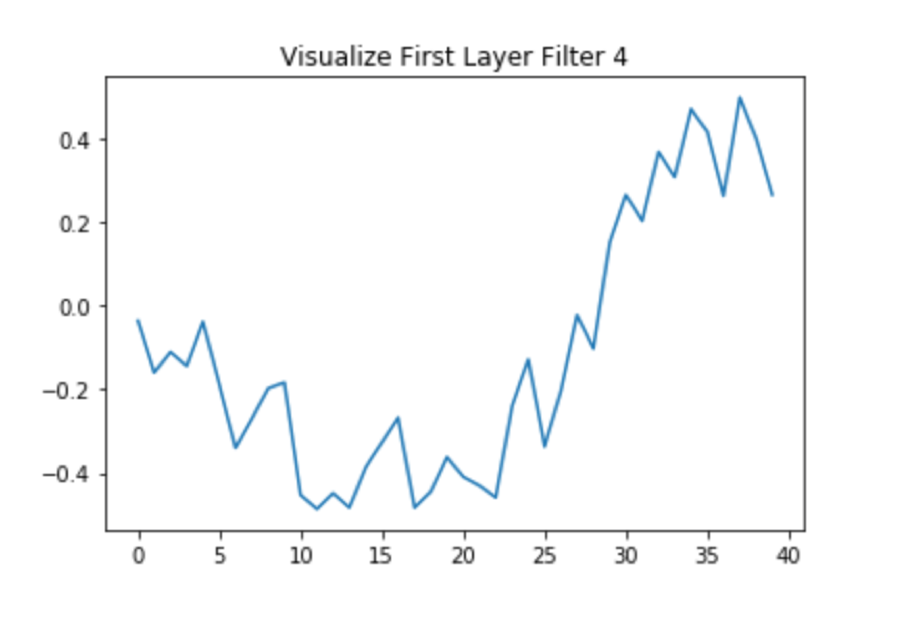

This demonstrates that our CNN is learning the shape of the SCR. 

# Resources:

### Data
[https://www.utdallas.edu/~nourani/Bioinformatics/Biosensor_Data/] 

### Bibliography:


[Seta et al. 2010]
Seta, Cornelia, et al. “Discriminating Stress From Cognitive Load Using a Wearable EDA Device - IEEE Journals & Magazine.” Design and Implementation of Autonomous Vehicle Valet Parking System - IEEE Conference Publication, Wiley-IEEE Press, Mar. 2010, ieeexplore.ieee.org/document/5325784/.


[Cho et al. 2017]
Cho, Dongrae. “Detection of Stress Levels from Biosignals Measured in Virtual Reality Environments Using a Kernel-Based Extreme Learning Machine.” Sensors, 2017, www.readbyqxmd.com/read/29064457/detection-of-stress-levels-from-biosignals-measured-in-virtual-reality-environments-using-a-kernel-based-extreme-learning-machine.

[Alexandratos 2014]
Alexandratos, Vsileios. “Mobile Real-Time Stress Detection.” Delft University of Technology, 2014, repository.tudelft.nl/islandora/object/uuid:c3e56b27-97ff-459b-9f85-dc05f8e3c088/datastream/OBJ.




### Assistance with Coding:
1D CNN Help:
https://keras.io/layers/convolutional/


For Decision Trees:
http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/


For Logistic Regression: 
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ARIMA model:
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


### CNN on Time-Series References
https://arxiv.org/pdf/1610.01683.pdf

https://arxiv.org/pdf/1611.06455.pdf